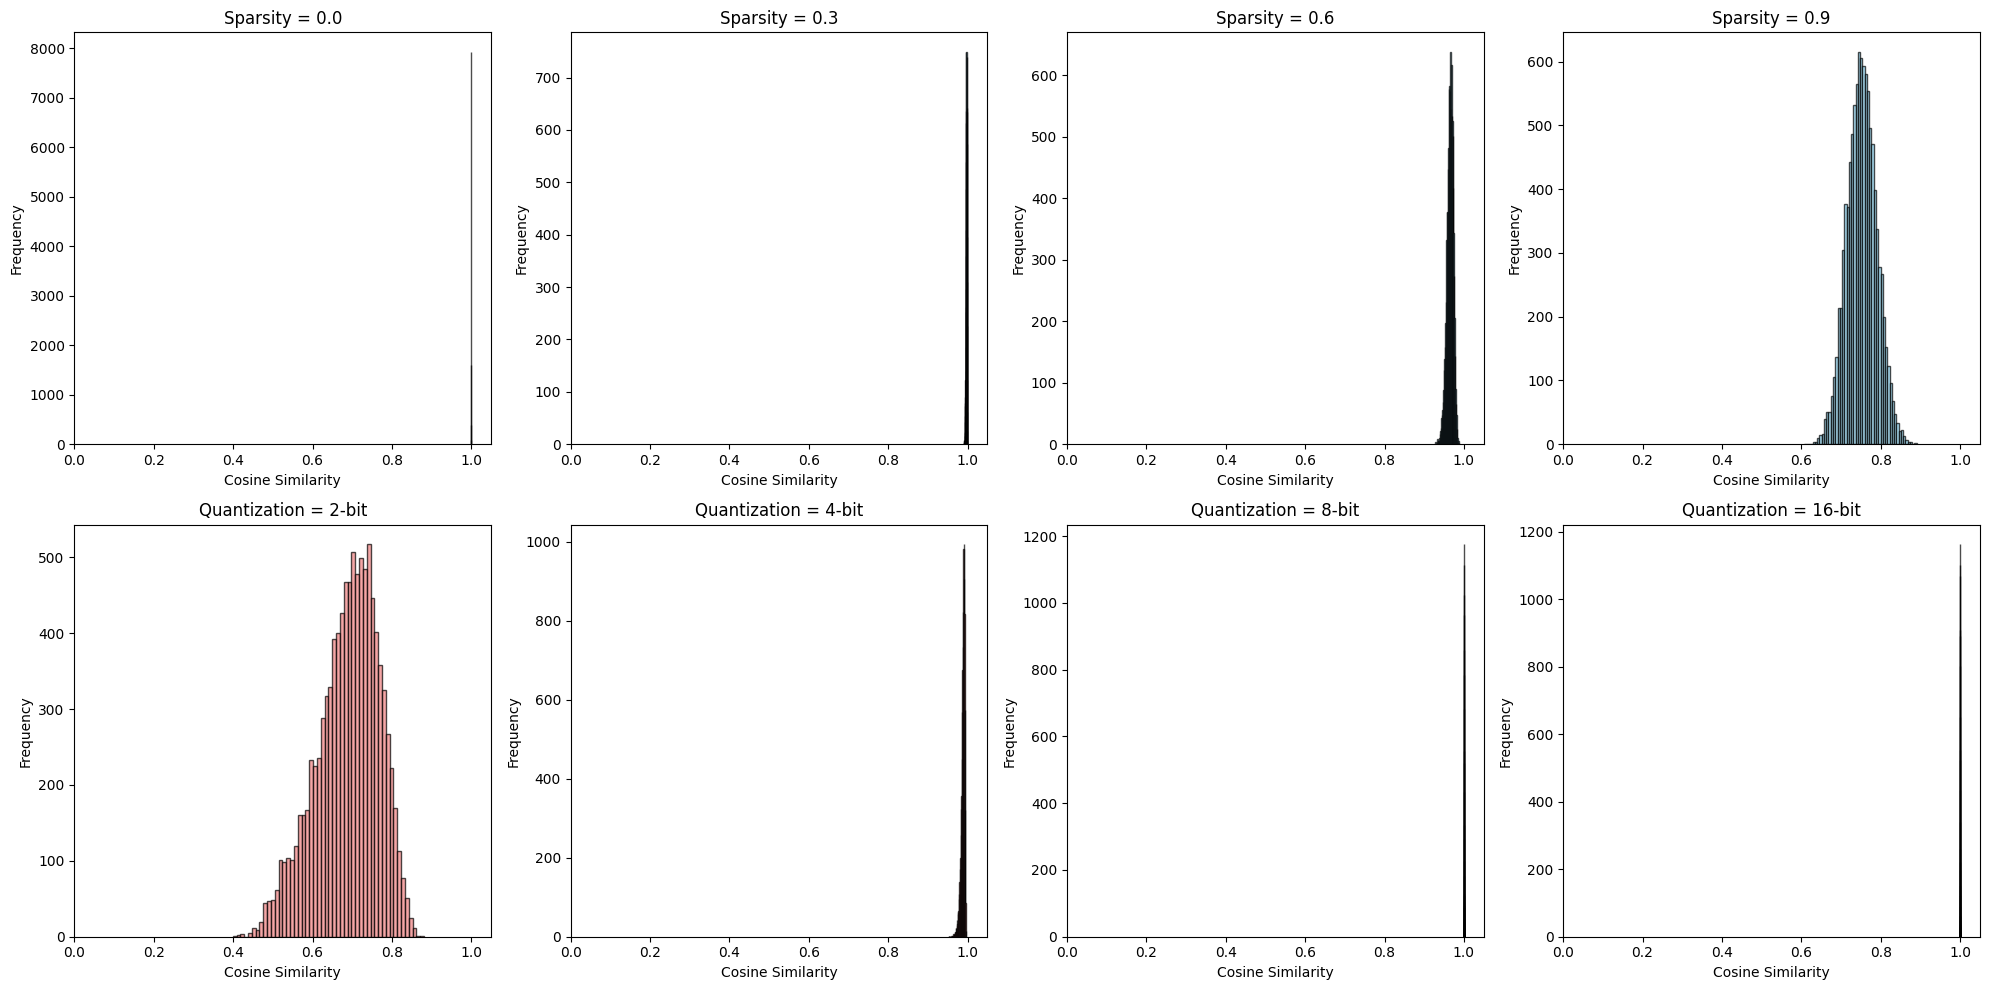

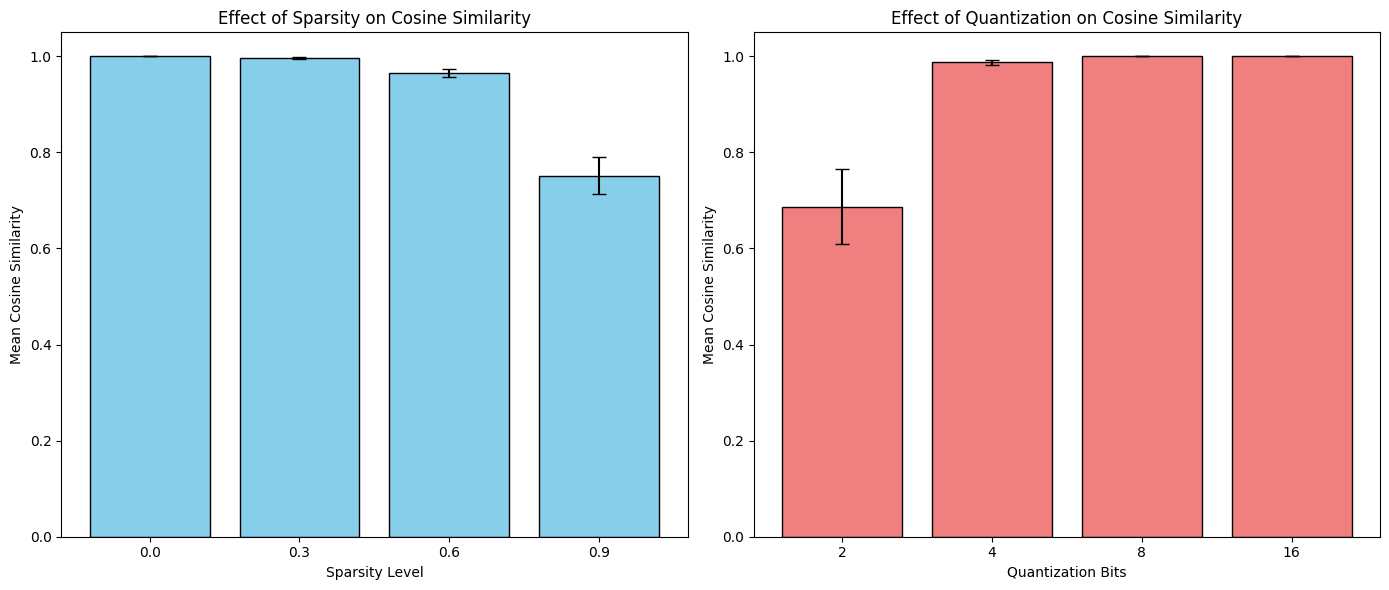

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_vectors = 10000
dim = 128
np.random.seed(42)

# Sparsity levels (fraction of zeros)
sparsity_levels = [0.0, 0.3, 0.6, 0.9]

# Quantization bits
quant_bits = [2, 4, 8, 16]

# Generate Laplace-distributed vectors (scale=1/sqrt(2) to match unit variance of Gaussian)
# Variance of Laplace(0, b) is 2*b^2. For unit variance, b = 1/sqrt(2)
b = 1 / np.sqrt(2)
vectors = np.random.laplace(loc=0.0, scale=b, size=(num_vectors, dim))

# Normalize original vectors to unit norm for consistent cosine similarity
norms = np.linalg.norm(vectors, axis=1, keepdims=True)
vectors_norm = vectors / norms

# Function to apply sparsity (keep top-k largest magnitude elements)
def apply_sparsity(vec, sparsity):
    if sparsity == 0.0:
        return vec.copy()
    k = int((1 - sparsity) * vec.shape[0])
    if k == 0:
        return np.zeros_like(vec)
    # Get indices of top-k absolute values
    idx = np.argpartition(np.abs(vec), -k)[-k:]
    sparse_vec = np.zeros_like(vec)
    sparse_vec[idx] = vec[idx]
    return sparse_vec

# Function to apply quantization (uniform quantization in range [-max_val, max_val])
def apply_quantization(vec, num_bits):
    if num_bits >= 32:  # No quantization
        return vec.copy()
    max_val = np.max(np.abs(vec))
    if max_val == 0:
        return vec.copy()
    # Number of quantization levels
    levels = 2 ** num_bits
    # Scale to [-levels/2, levels/2 - 1] (signed integer range)
    scaled = vec / max_val * (levels // 2 - 1)
    # Round to nearest integer
    quantized = np.round(scaled)
    # Scale back
    dequantized = quantized / (levels // 2 - 1) * max_val
    return dequantized

# Compute cosine similarities for sparsity
cos_sparse = {s: [] for s in sparsity_levels}
for s in sparsity_levels:
    for i in range(num_vectors):
        v = vectors_norm[i]
        v_sparse = apply_sparsity(v, s)
        # Normalize sparse vector (if not all zeros)
        norm_sparse = np.linalg.norm(v_sparse)
        if norm_sparse > 1e-12:
            v_sparse_norm = v_sparse / norm_sparse
            cos_sim = np.dot(v, v_sparse_norm)
        else:
            cos_sim = 0.0
        cos_sparse[s].append(cos_sim)
    cos_sparse[s] = np.array(cos_sparse[s])

# Compute cosine similarities for quantization
cos_quant = {b: [] for b in quant_bits}
for b in quant_bits:
    for i in range(num_vectors):
        v = vectors_norm[i]
        v_quant = apply_quantization(v, b)
        # Normalize quantized vector
        norm_quant = np.linalg.norm(v_quant)
        if norm_quant > 1e-12:
            v_quant_norm = v_quant / norm_quant
            cos_sim = np.dot(v, v_quant_norm)
        else:
            cos_sim = 0.0
        cos_quant[b].append(cos_sim)
    cos_quant[b] = np.array(cos_quant[b])

# Plot histograms
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# Sparsity histograms
for idx, s in enumerate(sparsity_levels):
    axs[0, idx].hist(cos_sparse[s], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axs[0, idx].set_title(f'Sparsity = {s:.1f}')
    axs[0, idx].set_xlabel('Cosine Similarity')
    axs[0, idx].set_ylabel('Frequency')
    axs[0, idx].set_xlim(0, 1.05)

# Quantization histograms
for idx, b in enumerate(quant_bits):
    axs[1, idx].hist(cos_quant[b], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    axs[1, idx].set_title(f'Quantization = {b}-bit')
    axs[1, idx].set_xlabel('Cosine Similarity')
    axs[1, idx].set_ylabel('Frequency')
    axs[1, idx].set_xlim(0, 1.05)

plt.tight_layout()
plt.show()

# Compute means and stds for bar plots
sparsity_means = [np.mean(cos_sparse[s]) for s in sparsity_levels]
sparsity_stds = [np.std(cos_sparse[s]) for s in sparsity_levels]

quant_means = [np.mean(cos_quant[b]) for b in quant_bits]
quant_stds = [np.std(cos_quant[b]) for b in quant_bits]

# Bar plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Sparsity bar plot
x_sparse = np.arange(len(sparsity_levels))
ax1.bar(x_sparse, sparsity_means, yerr=sparsity_stds, capsize=5, color='skyblue', edgecolor='black')
ax1.set_xticks(x_sparse)
ax1.set_xticklabels(sparsity_levels)
ax1.set_xlabel('Sparsity Level')
ax1.set_ylabel('Mean Cosine Similarity')
ax1.set_title('Effect of Sparsity on Cosine Similarity')
ax1.set_ylim(0, 1.05)

# Quantization bar plot
x_quant = np.arange(len(quant_bits))
ax2.bar(x_quant, quant_means, yerr=quant_stds, capsize=5, color='lightcoral', edgecolor='black')
ax2.set_xticks(x_quant)
ax2.set_xticklabels(quant_bits)
ax2.set_xlabel('Quantization Bits')
ax2.set_ylabel('Mean Cosine Similarity')
ax2.set_title('Effect of Quantization on Cosine Similarity')
ax2.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

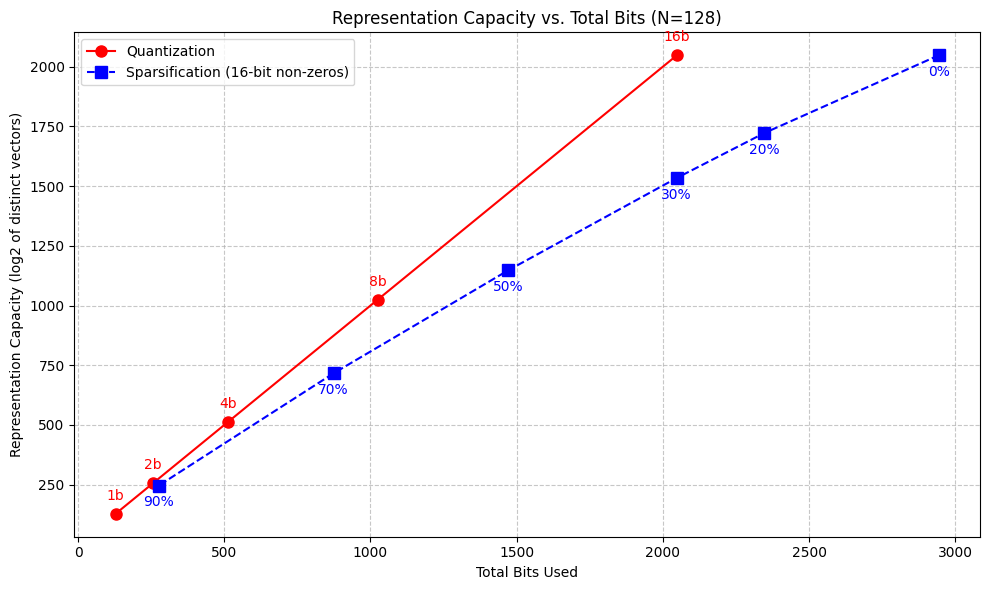

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def log2_representation_capacity(N, method='quantization', bits=16, sparsity=0.0):
    """
    Compute log2 of the number of distinct representable vectors for a given method.
    
    Parameters:
    - N: vector dimension
    - method: 'quantization' or 'sparsification'
    - bits: number of bits per element (for quantization) or for non-zero values (for sparsification)
    - sparsity: fraction of zeros (0.0 = dense, 0.9 = 90% zeros)
    
    Returns:
    - log2_capacity: log2 of total number of distinct vectors representable
    """
    if method == 'quantization':
        return bits * N
    
    elif method == 'sparsification':
        k = int(N * (1 - sparsity))
        if k == 0:
            return 0.0  # Only the zero vector
        
        # Compute log2(C(N, k)) using log gamma for numerical stability
        from math import lgamma, log
        log2_combinations = (lgamma(N + 1) - lgamma(k + 1) - lgamma(N - k + 1)) / log(2)
        log2_value_combinations = k * bits
        return log2_combinations + log2_value_combinations
    
    else:
        raise ValueError("Method must be 'quantization' or 'sparsification'")

def total_bits_used(N, method='quantization', bits=16, sparsity=0.0):
    """
    Compute total bits used to represent a vector.
    
    Parameters:
    - N: vector dimension
    - method: 'quantization' or 'sparsification'
    - bits: number of bits per element (for quantization) or for non-zero values (for sparsification)
    - sparsity: fraction of zeros (0.0 = dense, 0.9 = 90% zeros)
    
    Returns:
    - total_bits: total number of bits used
    """
    if method == 'quantization':
        return bits * N
    
    elif method == 'sparsification':
        k = int(N * (1 - sparsity))
        if k == 0:
            return 0  # Only the zero vector, no bits needed in theory
        
        # Index bits: we assume naive encoding (each index takes log2(N) bits)
        # In practice, you could use combinatorial indexing, but naive is simpler
        index_bits = k * np.ceil(np.log2(N))
        value_bits = k * bits
        return index_bits + value_bits
    
    else:
        raise ValueError("Method must be 'quantization' or 'sparsification'")

# Parameters
N = 128
quant_bits = [16, 8, 4, 2, 1]
sparsity_levels = [0.0, 0.2, 0.3, 0.5, 0.7, 0.9]

# Compute points for quantization
quant_capacities = []
quant_total_bits = []
for b in quant_bits:
    cap = log2_representation_capacity(N, 'quantization', bits=b)
    bits_used = total_bits_used(N, 'quantization', bits=b)
    quant_capacities.append(cap)
    quant_total_bits.append(bits_used)

# Compute points for sparsification (with 16-bit non-zero values)
sparse_capacities = []
sparse_total_bits = []
for s in sparsity_levels:
    cap = log2_representation_capacity(N, 'sparsification', bits=16, sparsity=s)
    bits_used = total_bits_used(N, 'sparsification', bits=16, sparsity=s)
    sparse_capacities.append(cap)
    sparse_total_bits.append(bits_used)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(quant_total_bits, quant_capacities, 'ro-', label='Quantization', markersize=8)
plt.plot(sparse_total_bits, sparse_capacities, 'bs--', label='Sparsification (16-bit non-zeros)', markersize=8)

# Annotate points
for i, b in enumerate(quant_bits):
    plt.annotate(f'{b}b', (quant_total_bits[i], quant_capacities[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center', color='red')

for i, s in enumerate(sparsity_levels):
    plt.annotate(f'{int(s*100)}%', (sparse_total_bits[i], sparse_capacities[i]), 
                 textcoords="offset points", xytext=(0,-15), ha='center', color='blue')

plt.xlabel('Total Bits Used')
plt.ylabel('Representation Capacity (log2 of distinct vectors)')
plt.title(f'Representation Capacity vs. Total Bits (N={N})')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

| Method           | Configuration    | log₂(Capacity) | Distinct Vectors |
|------------------|------------------|----------------|------------------|
| **Quantization** | 16-bit           | 2048           | $2^{2048}$     |
|                  | 8-bit            | 1024           | $2^{1024}$     |
|                  | 4-bit            | 512            | $2^{512}$      |
|                  | 2-bit            | 256            | $2^{256}$      |
|                  | 1-bit            | 128            | $2^{128}$      |
| **Sparsification** | 0% sparse (dense) | 2048           | $2^{2048}$     |
|                  | 20% sparse       | 1722           | $2^{1722}$     |
|                  | 30% sparse       | 1534           | $2^{1534}$     |
|                  | 50% sparse       | 1148           | $2^{1148}$     |
|                  | 70% sparse       | 717            | $2^{717}$      |
|                  | 90% sparse       | 246            | $2^{246}$      |

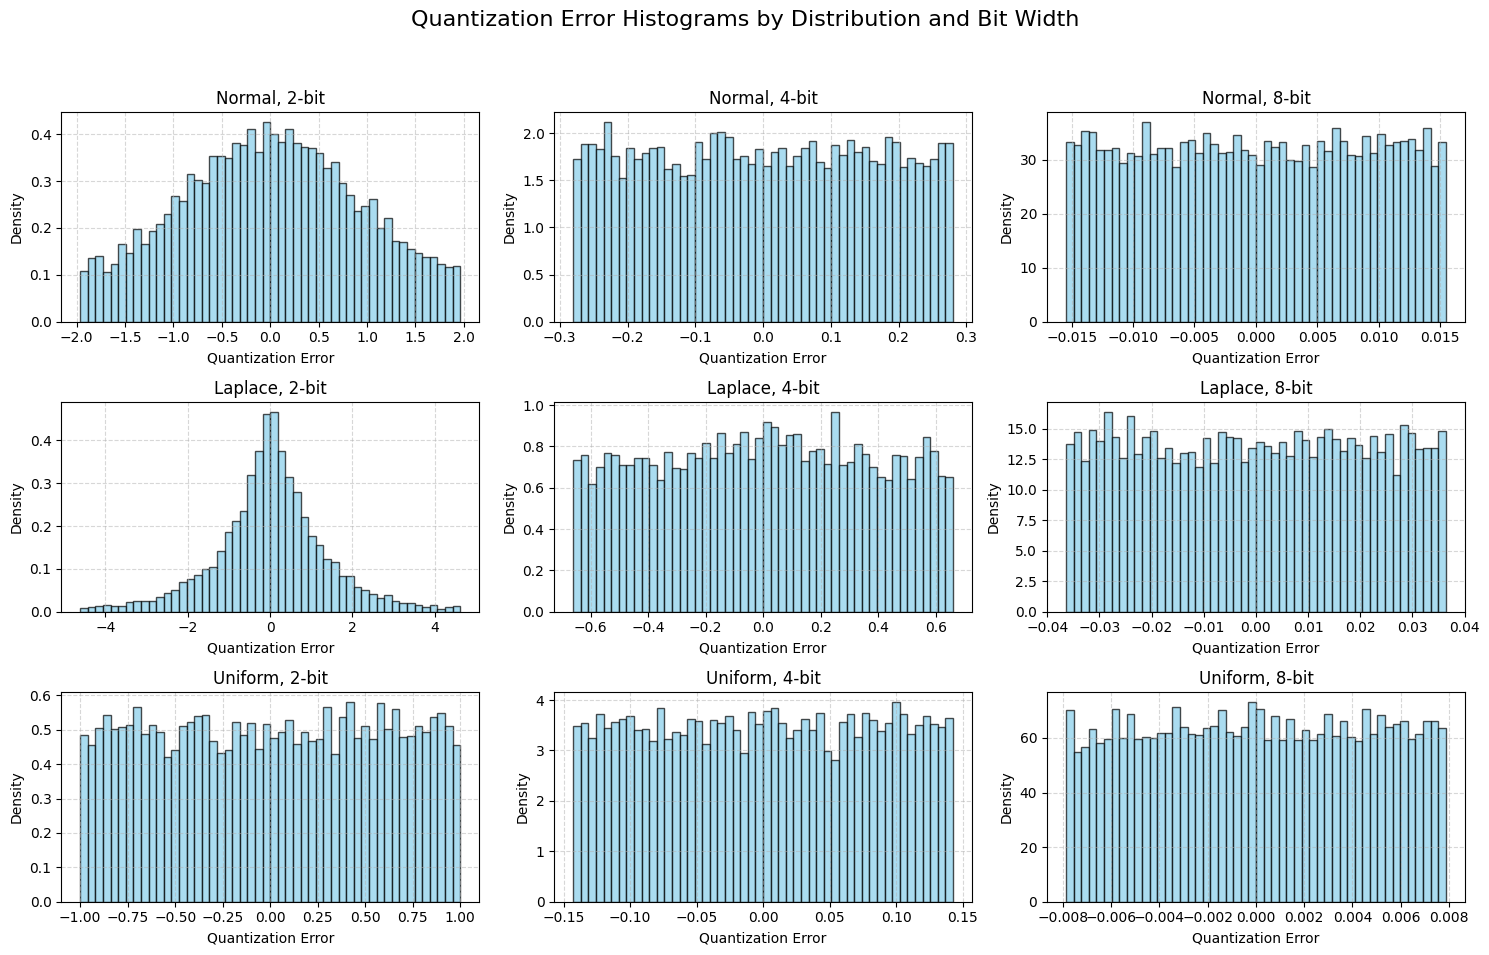

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def quantize(v, s, num_bits, signed=True):
    """
    Quantize vector v using step size s and num_bits.
    Returns quantized values at original scale (v_hat).
    """
    if signed:
        QN = 2**(num_bits - 1)
        QP = 2**(num_bits - 1) - 1
    else:
        QN = 0
        QP = 2**num_bits - 1
    
    # Clip and round
    v_scaled = v / s
    v_clipped = np.clip(v_scaled, -QN, QP)
    v_bar = np.round(v_clipped)  # nearest integer
    v_hat = v_bar * s
    return v_hat

def compute_step_size_mse(v, num_bits, signed=True):
    """
    Compute step size s that minimizes MSE for uniform quantization.
    For simplicity, use range-based s: s = (max - min) / (2^b - 1)
    But for signed: range = max - min, levels = 2^b - 1 (excluding one sign bit?)
    Actually, for symmetric signed: s = max(|v|) / (2^(b-1) - 1) if non-zero
    We'll use: s = (max(v) - min(v)) / (2**num_bits - 1) for unsigned,
    and for signed: s = max(abs(v)) / (2**(num_bits-1) - 1) if max(abs(v)) > 0 else 1.0
    """
    if signed:
        max_abs = np.max(np.abs(v))
        if max_abs == 0:
            return 1.0
        # Avoid division by zero for 1-bit (edge case)
        if num_bits == 1:
            return max_abs  # only two levels: -s and +s? but 1-bit signed is tricky
        s = max_abs / (2**(num_bits - 1) - 1)
    else:
        v_min, v_max = np.min(v), np.max(v)
        if v_max == v_min:
            return 1.0
        s = (v_max - v_min) / (2**num_bits - 1)
    return s

# Generate data from different distributions
np.random.seed(42)
N = 10000

# Normal (Gaussian)
normal_data = np.random.normal(loc=0.0, scale=1.0, size=N)

# Laplace
laplace_data = np.random.laplace(loc=0.0, scale=1.0, size=N)

# Uniform
uniform_data = np.random.uniform(low=-2.0, high=2.0, size=N)

distributions = {
    'Normal': normal_data,
    'Laplace': laplace_data,
    'Uniform': uniform_data
}

bits_list = [2, 4, 8]

# Prepare subplots
fig, axes = plt.subplots(len(distributions), len(bits_list), figsize=(15, 10))
fig.suptitle('Quantization Error Histograms by Distribution and Bit Width', fontsize=16)

for i, (dist_name, data) in enumerate(distributions.items()):
    for j, bits in enumerate(bits_list):
        # Determine if signed (all our data are centered at 0, so use signed)
        signed = True
        
        # Compute step size
        s = compute_step_size_mse(data, bits, signed=signed)
        
        # Quantize
        data_quant = quantize(data, s, bits, signed=signed)
        
        # Compute error
        error = data - data_quant
        
        # Plot histogram
        ax = axes[i, j]
        ax.hist(error, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
        ax.set_title(f'{dist_name}, {bits}-bit')
        ax.set_xlabel('Quantization Error')
        ax.set_ylabel('Density')
        ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Q(X) = X + NQ   , NQ = X - Q(X),   Q(x) = round(x/s), NQ ~ delta*X